In [185]:
import time
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, \
                             DataLoader, RandomSampler, SequentialSampler

from IPython.display import clear_output
from pylab import rcParams

rcParams['figure.figsize'] = 15, 7
%matplotlib inline

sns.set(font_scale=1.3, palette='Set2')

In [186]:
!pip install lightning

In [187]:
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint

# Данные

## Биология

#### **Профиль биология**

### Загрузка данных
В этом задании вы будете работать с данными о распространении COVID-19, их можно скачать [здесь](https://www.kaggle.com/datasets/gpreda/coronavirus-2019ncov). Мы будем предказывать показатель смертности, потому что способы измерения выздоровевших и заболевших разнятся между регионами.

 В данных представлены следующие столбцы:

* `Country/Region` &mdash; страна или регион,

* `Province/State` &mdash; город или населенный пункт,
* `Latitude` &mdash; географическая широта,
* `Longitude` &mdash; географическая долгота,
* `Confirmed` &mdash; кол-во подтвержденных случаев заболевания,
* `Recovered` &mdash; кол-во подтвержденных случаев выздоровления,
* `Deaths` &mdash; кол-во смертей,
* `Date` &mdash; дата.

Выгрузим датасет.

In [188]:
data = pd.read_csv('/content/covid-19-all.csv')
data['Date'] = pd.to_datetime(data['Date'])

<ipython-input-188-7d3bd9754880>:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/covid-19-all.csv')


Установим в качестве индекса дату.

In [189]:
data.set_index('Date', inplace=True)
data.head()

Country/Region Province/State  Latitude  Longitude  Confirmed  \
Date                                                                       
2021-01-01            NaN            NaN       NaN        NaN    51526.0   
2021-01-01            NaN            NaN       NaN        NaN    58316.0   
2021-01-01            NaN            NaN       NaN        NaN    99897.0   
2021-01-01            NaN            NaN       NaN        NaN     8117.0   
2021-01-01            NaN            NaN       NaN        NaN    17568.0   

            Recovered  Deaths  
Date                           
2021-01-01    41727.0  2191.0  
2021-01-01    33634.0  1181.0  
2021-01-01    67395.0  2762.0  
2021-01-01     7463.0    84.0  
2021-01-01    11146.0   405.0

Избавимся от None если они есть.

In [190]:
data.dropna(inplace=True)


Выберем страну и регион, где хотим предсказывать.

In [191]:
country = 'Russia'
region = 'Saint Petersburg'

filtered_data = data[(data['Country/Region'] == country) & (data['Province/State'] == region)]

filtered_data.head()

Country/Region    Province/State   Latitude  Longitude  Confirmed  \
Date                                                                           
2020-06-01         Russia  Saint Petersburg  59.960674  30.158655    16313.0   
2020-06-02         Russia  Saint Petersburg  59.960674  30.158655    16689.0   
2020-06-03         Russia  Saint Petersburg  59.960674  30.158655    17069.0   
2020-06-04         Russia  Saint Petersburg  59.960674  30.158655    17444.0   
2020-06-05         Russia  Saint Petersburg  59.960674  30.158655    17822.0   

            Recovered  Deaths  
Date                           
2020-06-01     5748.0   213.0  
2020-06-02     6008.0   223.0  
2020-06-03     6331.0   240.0  
2020-06-04     6695.0   264.0  
2020-06-05     7076.0   291.0

Удалим лишние столбцы в выбранных данных.

In [192]:
columns = ['Confirmed','Recovered', 'Deaths']
data_new = filtered_data[columns]
data_new

Confirmed  Recovered  Deaths
Date                                    
2020-06-01    16313.0     5748.0   213.0
2020-06-02    16689.0     6008.0   223.0
2020-06-03    17069.0     6331.0   240.0
2020-06-04    17444.0     6695.0   264.0
2020-06-05    17822.0     7076.0   291.0
...               ...        ...     ...
2020-12-27   227097.0   136239.0  7378.0
2020-12-28   230845.0   138487.0  7453.0
2020-12-29   234602.0   140596.0  7532.0
2020-12-30   238366.0   144874.0  7610.0
2020-12-31   242124.0   148447.0  7694.0

[214 rows x 3 columns]

Посмотрим на данные. Постройте графики заболевших, выздоровевших и количества смертей.

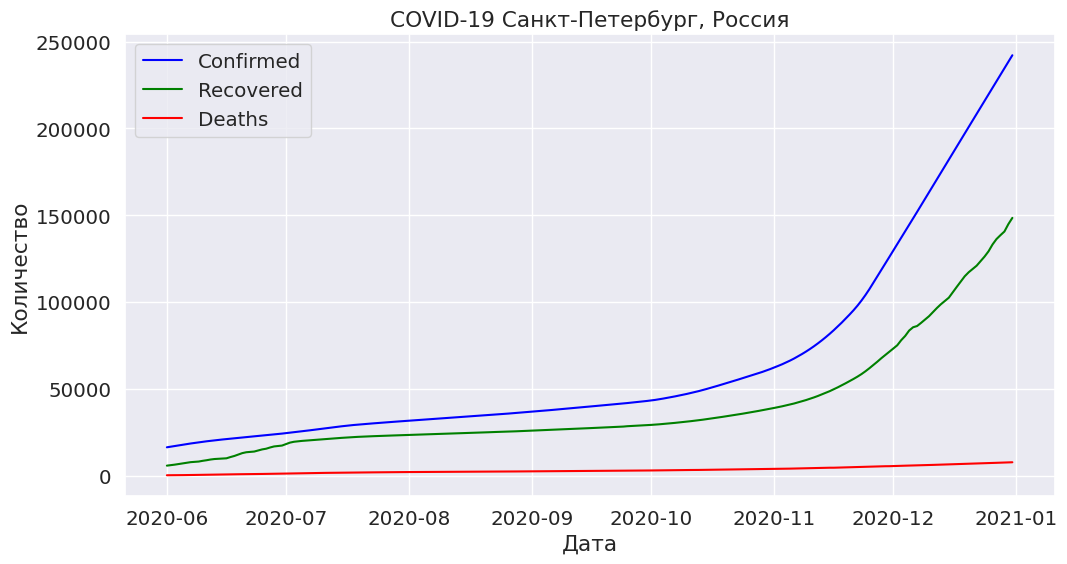

In [193]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

sns.lineplot(data=data_new, x=data_new.index, y='Confirmed', label='Confirmed', color='blue')
sns.lineplot(data=data_new, x=data_new.index, y='Recovered', label='Recovered', color='green')
sns.lineplot(data=data_new, x=data_new.index, y='Deaths', label='Deaths', color='red')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))


plt.title('COVID-19 Санкт-Петербург, Россия')
plt.xlabel('Дата')
plt.ylabel('Количество')

plt.legend()

plt.show()


## Физика

#### **Профиль физика**

В этом задании мы будем работать с данными о загрязнении воздуха в Пекине, которые можно скачать [здесь](https://github.com/Afkerian/Beijing-Multi-Site-Air-Quality-Data-Data-Set/blob/main/data/beijing%2Bmulti%2Bsite%2Bair%2Bquality%2Bdata/PRSA2017_Data_20130301-20170228.zip). В этой папке представлены несколько таблиц, данные в них сняты с различных станций. Для дальнейшей работы выберите любую таблицу.

 В данных представлены следующие колонки:

* `year, month, day, hour`  &mdash; год, месяц, день и час измерения

* `PM2.5` концентрация PM2.5 (ug/m^3). `PM2.5` &mdash; описывает мелкие вдыхаемые частицы, диаметр которых обычно составляет 2,5 микрометра и меньше.
* `PM10` концентрация PM10 (ug/m^3). `PM10` &mdash; любые твердые частицы в воздухе диаметром 10 микрометров или меньше, включая дым, пыль, сажу, соли, кислоты и металлы.
* `SO2`: концентрация SO2 (ug/m^3),
* `NO2`: концентрация NO2 (ug/m^3),
* `CO`: концентрация CO (ug/m^3),
* `O3`: концентрация O3 (ug/m^3),
* `TEMP`: температура (degree Celsius),
* `PRES`: давление (hPa=100Pa),
* `DEWP`: температура точки росы (degree Celsius),
* `RAIN`: атмосферные осадки (mm),
* `wd`: направление ветра,
* `WSPM`: скорость ветра (m/s),
* `station`: название станции.

Таргетом в этой задаче будет показатель загрязнения воздуха `PM10`.

Выгрузим данные.

Создадим отдельный столбец в формате даты.

Выкинем лишние столбцы.

Очистим от null.

Посмотрим на данные. Постройте временные зависимости для физических параметров.

Попробуем сделать ещё что-то с данными, потому что модель не сможет определять сразу суточную зависимость, тенденции на месяце и периодичные процессы по сезонам.

Посмотрим, есть ли какая-нибудь суточная периодичность. Постройте небольшой кусок какой-нибудь из зависимостей длиной несколько дней.

Как мы видим, никакой периодичности за сутки не обнаружилось, поэтому преобразование фурье для того, чтобы убрать быстрые осцилляции, не поможет и может сильно исказить картину.

Избавимся от суточных изменений, усреднив по дню. Для этого мы не учитывали часы в столбце дней, чтобы было удобнее усреднять.

Установите дату как индекс.

Посмотрим, что получилось. Снова постройте зависимости.

Получилось уже лучше, чем было.

Оставьте те параметры, которые хотите предсказывать. Учтите, что шумные данные ухудшают возможности в предсказании.

# Модели и обучение

## Вспомогательные функции

Напишите класс датасета для данных в виде последовательности.

In [194]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, timesteps):
        self.data = data
        self.timesteps = timesteps

    def __len__(self):
        return len(self.data)-self.timesteps # количество подпоследовательностей заданной длины

    def __getitem__(self, index):
        X = self.data[index:index+self.timesteps]
        y = self.data[index+self.timesteps]
        return X, y

Здесь мы создаём функции для обучения, для вывода кривых обучения и для рекурсивного предсказания.

In [195]:
def evaluate_ts_model(model, start_seq, test_data, scaler, device='cpu'):
    '''
    Функция для проверки качества модели на обучающем отрезке ряда.

    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.
    :param scaler: обученный стандартизатор, имеющий метод inverse_transform

    :return: результаты предсказания.
    '''
    result = []

    # отключаем дропауты
    model.train(False)
    # первые 40 чисел перед тестом оборачиваем в тензор размера (1, seq_len, 3)
    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0)

    with torch.no_grad():
        for i in range(len(test_data)):
            # делаем предсказание
            logits = model(input_tensor[:,i:,:]).unsqueeze(0)
            #print("Shape of logits:", logits.shape)
            # присоединяем предсказанное значение к последовательности:
            #                       ((1, timestep, 3),   (1, 1, 3),   по оси 1 )
            input_tensor = torch.cat((input_tensor, logits), 1)

            # обратное преобразование к нормальным числам
            logits = scaler.inverse_transform(logits.cpu().numpy().squeeze(0))

            # результат сохраняем
            result.append(logits.squeeze())

    return np.array(result)

Создадим класс модели.

In [196]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_lstm_layers, use_pool=False):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers  = num_lstm_layers
        self.input_size  = input_size

        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            dropout=0.2) # LSTM-модель с batch_first=True и dropout=0.2

        # Размерность пространства выхода последнего LSTM-слоя равна hidden_size.
        # Линейный слой нужен, чтобы преобразовать выход LSTM к нужному размеру output_size.
        self.fc = nn.Linear(in_features=hidden_size,
                            out_features=output_size) # добавьте линейный слой

        # Пуллинг
        self.pool = nn.AdaptiveAvgPool1d(1) # добавьте усредняющий все выходы пуллинг-слой
        self.use_pool = use_pool


    def forward(self, input_seq):

        # инициализируем начальные скрытые состояния
        h_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(device=input_seq.device)
        c_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(device=input_seq.device)

        out, (_, _) = self.lstm(input_seq, (h_0, c_0))

        if self.use_pool:
            # берем среднее от векторов для всей последовательности
            out_to_fc = self.pool(out.transpose(1, 2)).squeeze(-1)
        else:
            # берем последний выходной вектор
            out_to_fc = out[:, -1, :]

        return self.fc(out_to_fc)

In [197]:
class TSModel(pl.LightningModule):
    def __init__(self, model, lr=5e-4):
        super().__init__()
        self.lr = lr
        self.criterion = nn.MSELoss()
        self.save_hyperparameters()
        self.model = model
        self.predictions = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x_batch, y_batch = batch
        output = self.forward(x_batch)
        loss = self.criterion(output.squeeze(), y_batch.squeeze())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x_batch, y_batch = batch
        output = self.forward(x_batch)
        loss = self.criterion(output.squeeze(), y_batch.squeeze())
        self.log('val_loss', loss)
        return loss

    def transfer_batch_to_device(self, batch, device, dataloader_idx):
        x_batch, y_batch = batch
        x_batch = x_batch.type(torch.float32).to(device)
        y_batch = y_batch.type(torch.float32).to(device)
        return x_batch, y_batch

Напишем функцию для визуализации результатов предсказания.

In [198]:
def plot_results(y_to_train, y_to_test=None, y_forecast=None):
    """
        Функция для визуализации временного ряда и предсказания.

        Параметры:
            - y_to_train: pd.Series
                Временной ряд, на котором обучалась модель.
            - y_to_test: pd.Series
                Временной ряд, который предсказывает модель.
            - y_forecast: array
                Предсказания модели.
            - plot_conf_int: bool
                Надо ли строить предсказательного интервал.
            - left_bound: array
                Левая граница предсказательного интервала.
            - right_bound: array
                Правая граница предсказательного интервала.
    """
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(len(y_to_train)), y_to_train, label='train')

    if y_to_test is not None:
        plt.plot(np.arange(len(y_to_train), len(y_to_train) + len(y_to_test)), y_to_test,  label='test')
        if y_forecast is not None:
            plt.plot(np.arange(len(y_to_train), len(y_to_train) + len(y_to_test)), y_forecast, label='prediction')
    plt.legend()
    plt.show()

## Биология

Разделим выборку на тест и трейн.

In [199]:
test_time = pd.Timestamp('2020-12-01')
train_bio = data_new[data_new.index < test_time]
test_bio = data_new[data_new.index >= test_time]

Посмотрим на то, что получилось.

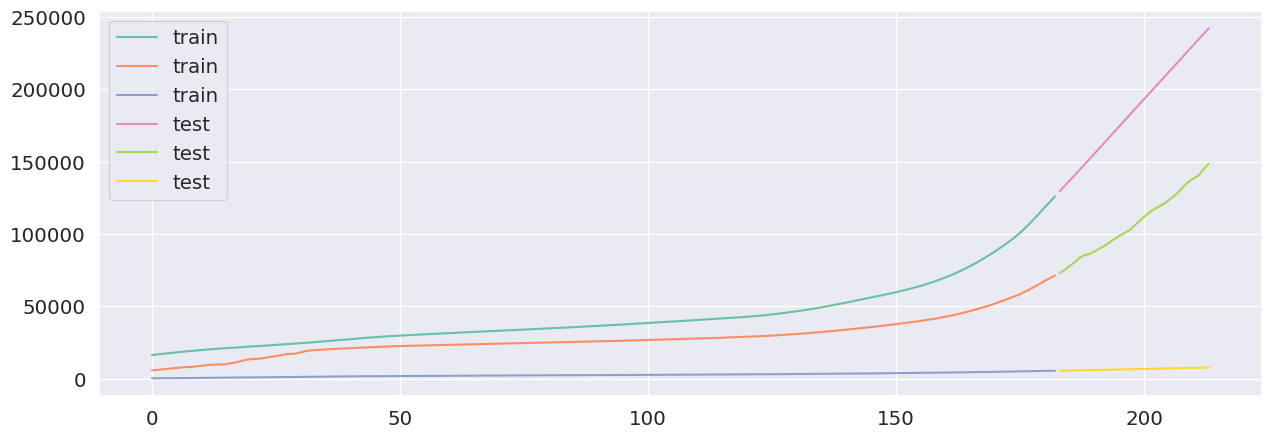

In [200]:
plot_results(train_bio, test_bio)

Преобразуем данные.

In [211]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_scaled = scaler.fit_transform(train_bio)
test_data_scaled = scaler.transform(test_bio)

Зададим длину подпоследовательности, размер батча, девайс.

In [202]:
timesteps = 5
batch_size = 32

Преобразуем к датасету с помощью нашего класса и сделаем генератор батчей.

In [203]:
train_dataset = TSDataset(train_data_scaled, timesteps)
test_dataset = TSDataset(test_data_scaled, timesteps)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Инициализируем модель.

In [213]:
input_size=train_bio.shape[1]
lstm_1 = LSTM(
            input_size=input_size,
            output_size=3,
            hidden_size=64,
            num_lstm_layers=2,
            use_pool=False
            )

lstm_model_1 = TSModel(
                    model=lstm_1,
                    lr=5e-4,
                    )
# т. к. зависимость сложная, то learning_rate стоит взять совсем небольшой

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='max')
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/lstm_1")
trainer = pl.Trainer(logger=tb_logger,
                     accelerator='cpu',
                     max_epochs=500,
                     devices=1,
                     val_check_interval=5,
                     callbacks=[checkpoint_callback])

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Обучаем её.

In [214]:
trainer.fit(lstm_model_1, train_loader, test_loader)

INFO: 
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | model     | LSTM    | 51.1 K | train
----------------------------------------------
51.1 K    Trainable params
0         Non-trainable params
51.1 K    Total params
0.205     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | model     | LSTM    | 51.1 K | train
----------------------------------------------
51.1 K    Trainable params
0         Non-trainable params
51.1 K    Total params
0.205     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Создадим предсказания на тесте.

In [215]:
lstm_model_1.cpu()
start_seq = train_data_scaled[-timesteps:]
test_pred=evaluate_ts_model(lstm_model_1, start_seq, scaler.transform(test_bio), scaler)

Сравним предсказание с реальностью.

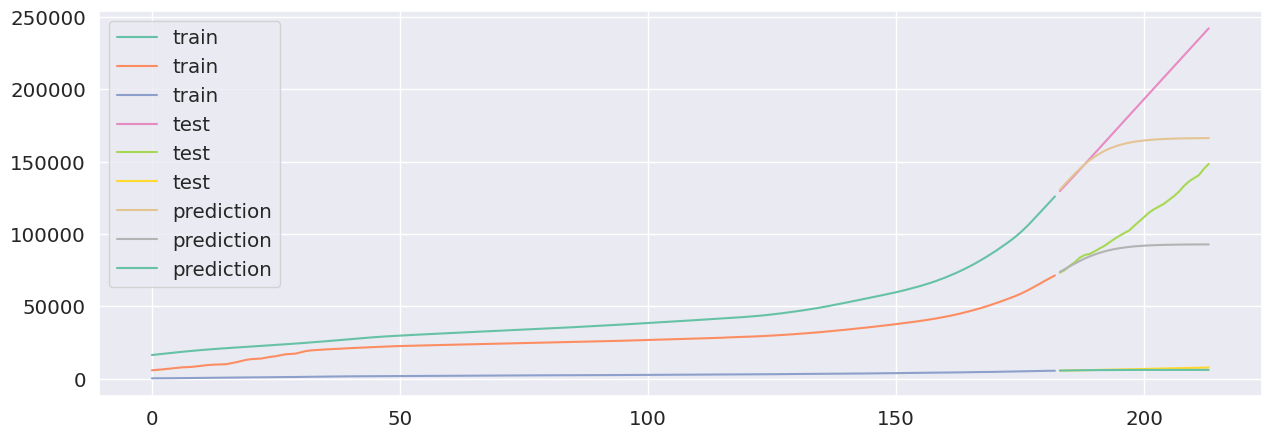

In [216]:
plot_results(train_bio, test_bio, test_pred)

**Вывод**
Я провела два опыта (обучение на 50 и 500 эпохах), во втором случае результаты действительно улучшились, val_loss уменьшилось в два раза, также по итоговому графику видна разница, prediction стал больше похож на test.

In [218]:
![val_loss на 50 эпохах](50.jpg)

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[val_loss на 50 эпохах](50.jpg)'


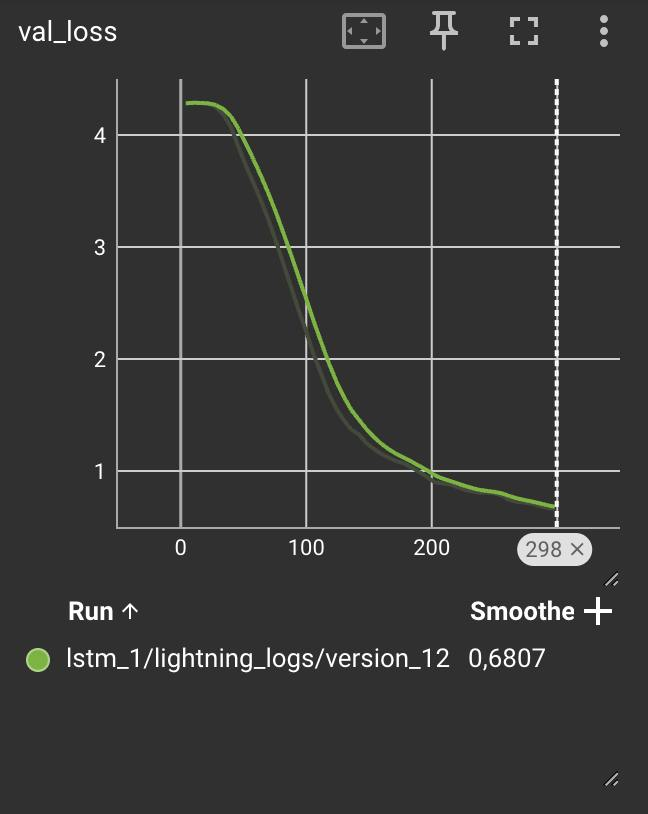

In [219]:
from IPython.display import Image, display

display(Image(filename='50.jpg'))

In [220]:
![val_loss на 500 эпохах](500.jpg)

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `[val_loss на 500 эпохах](500.jpg)'


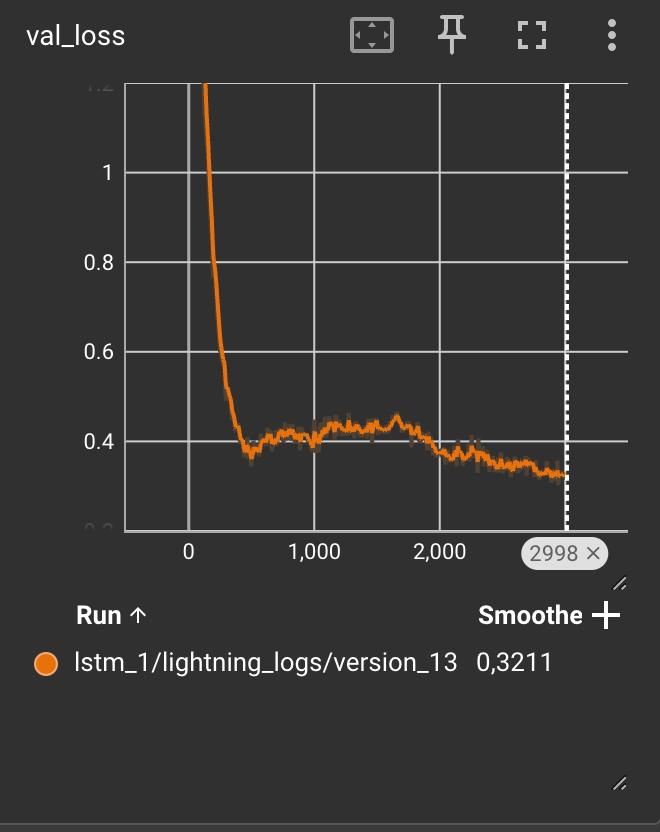

In [221]:
from IPython.display import Image, display

display(Image(filename='500.jpg'))

## Физика

Разделим выборку на тест и трейн.

Посмотрим на то, что получилось.

Отнормируем датасет.

Зададим длину последовательности, размер батча и девайс.

Инициализируем датасет и создадим dataloader к нему.

Инициализируем модель.

Обучим её.

Получим предсказания на тесте.

Сравним предсказания с истинными значениями.

**Вывод**